In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np

In [3]:
import torchvision
from PIL import Image

In [4]:
def parse_data(datadir):
    img_list = []
    ID_list = []
    file_list = []
    for root, directories, filenames in os.walk(datadir):
          
          for filename in filenames:
              file_list.append(filename)
              if filename.endswith('.png'):
                  filei = os.path.join(root, filename)
                  img_list.append(filei)
                  ID_list.append(root.split('/')[-1])

    # construct a dictionary, where key and value correspond to ID and target
    uniqueID_list = list(set(ID_list))
    class_n = len(uniqueID_list)
    target_dict = dict(zip(uniqueID_list, range(class_n)))
    label_list = [target_dict[ID_key] for ID_key in ID_list]
    
    

    print('{}\t\t{}\n{}\t\t{}'.format('#Images', '#Labels', len(img_list), len(set(label_list))))
    return img_list, label_list, class_n

In [5]:
img_list, label_list, class_n = parse_data("cohn-kanade-trunc")

#Images		#Labels
1779		13


In [6]:
class ImageDataset(Dataset):
    def __init__(self, file_list, target_list):
        self.file_list = file_list
        self.target_list = target_list
        self.n_class = len(list(set(target_list)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img_pil = torchvision.transforms.Resize((224,224))(img)
        img = torchvision.transforms.ToTensor()(img_pil)
        if img.shape[0] == 3:
            img = torchvision.transforms.Grayscale(num_output_channels=1)(img_pil)
            img = torchvision.transforms.ToTensor()(img)
        label = self.target_list[index]
        return img, label

In [7]:
dataset = ImageDataset(img_list,label_list)

In [8]:
len(dataset)

1779

In [9]:
train_dataset, dev_dataset = torch.utils.data.random_split(dataset, (1000,779))

In [10]:
# for i in range(len(train_dataset)):
#     print(train_dataset[i][0].shape)

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                               shuffle=True, num_workers=8)

In [12]:
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=64, 
                                               shuffle=True, num_workers=8)

In [13]:
class AttentionLayer(nn.Module):
    def __init__(self, input1_size, input2_size):
        super(AttentionLayer, self).__init__()

        self.attention_fclayer = nn.Linear(input2_size, input1_size)
        
    def forward(self, input1, input2):
        
        self.input1 = input1
        self.input2 = input2
        
        self.batch, self.outchannel1, self.h1, self.w1 = input1.shape
        self.batch, self.outchannel2 = input2.shape
        
        input2_rescaled = self.attention_fclayer(self.input2)
        
        input2_bmm = input2_rescaled.view(self.batch,self.outchannel1,1)
        
        compat_scores = torch.zeros((self.batch, self.h1*self.w1))

        for h in range(self.h1):
            for w in range(self.w1):
                input1_bmm = self.input1[:,:,h,w].view(self.batch,1,self.outchannel1)
                compat_scores[:,h*self.w1+w] = torch.bmm(input1_bmm, input2_bmm).squeeze()
        
        normalized_compat_scores = F.softmax(compat_scores)
        
        bmm_arg2 = self.input1.view(self.batch,self.outchannel1,self.h1*self.w1,1)
        bmm_argtemp = normalized_compat_scores.view(self.batch,1,self.h1*self.w1).repeat(1,self.outchannel1,1)
        bmm_arg1 = bmm_argtemp.view(self.batch,self.outchannel1,1,self.h1*self.w1)
        
        g_mod = torch.zeros((self.batch, self.outchannel1))
        
        for b in range(self.batch):
            g_mod[b,:] = torch.bmm(bmm_arg1[b,:,:,:], bmm_arg2[b,:,:,:]).squeeze()
        
        return g_mod

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        self.num_classes = 13
        channels = [1, 64, 128, 256] # this needs to be modified according to num_blocks
        
        self.convlayer1 = ConvBlock(C_in=channels[0], C_out=channels[1], kernel_size=5, stride=1)
        self.convlayer2 = ConvBlock(C_in=channels[1], C_out=channels[2], kernel_size=5, stride=1)
        self.convlayer3 = ConvBlock(C_in=channels[2], C_out=channels[3], kernel_size=5, stride=1)
        
#         for i in range(num_blocks):
#             layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        self.dropoutlayer1 = nn.Dropout(p=0.25)
        
#         layers.append(nn.Dropout(p=0.25))
        
        self.flattenlayer = Flatten()
        
#         layers.append(Flatten())
        
        self.fclayer1 = nn.Linear(256*24*24, 512)
        
#         layers.append(nn.Linear(256*24*24, 512))
        
        self.dropoutlayer2 = nn.Dropout(p=0.5)
        
        self.attlayer1 = AttentionLayer(channels[1],512)
        self.attlayer2 = AttentionLayer(channels[2],512)
        self.attlayer3 = AttentionLayer(channels[3],512)
        
#         layers.append(nn.Dropout(p=0.5))
        
#         fclayer2 = nn.Linear(512, num_classes)
        
#         layers.append(nn.Linear(512, num_classes))
        
#         self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        self.out1 = self.convlayer1(x)
        self.out2 = self.convlayer2(self.out1)
        self.out3 = self.convlayer3(self.out2)
        self.out4 = self.dropoutlayer1(self.out3)
        self.out5 = self.flattenlayer(self.out4)
        self.out6 = self.fclayer1(self.out5)
        self.out7 = self.dropoutlayer2(self.out6)
        
        self.attout1 = self.attlayer1(self.out1,self.out7)
        self.attout2 = self.attlayer2(self.out2,self.out7)
        self.attout3 = self.attlayer3(self.out3,self.out7)
        
        self.attout = torch.cat((self.attout1,self.attout2,self.attout3),1)
        
        _, self.att_size = self.attout.shape
        
        self.fclayer2 = nn.Linear(self.att_size, self.num_classes)
        self.final_out = self.fclayer2(self.attout)
        
        return self.attout

In [15]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
device = torch.device("cuda" if cuda else "cpu")
print(model)
print(model(dataset[0][0].unsqueeze(dim=0)))

BaselineModel(
  (convlayer1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (convlayer2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (convlayer3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (dropoutlayer1): Dropout(p=0.25)
  (flattenlayer): Flatten()
  (fclayer1): Linear(in_features=147456, out_features=512, bias=True)
  (dropoutlayer2): Dropout(p=0.5)
  (attlayer1): AttentionLayer(
    (attention_fclayer): Linear(in_features=512, out_features=64, bias=True)
  )
  (attlayer2): Attentio

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [27]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                logging.debug('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_losses.append(avg_loss)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        eval_accs.append(test_accuracy)
        print('Epoch: {}\tTrain Loss: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, avg_loss, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracy = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracy/total

In [ ]:
train_losses, eval_losses, eval_accs = train(model,200, train_dataloader,dev_dataloader)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [20]:
import matplotlib.pyplot as plt

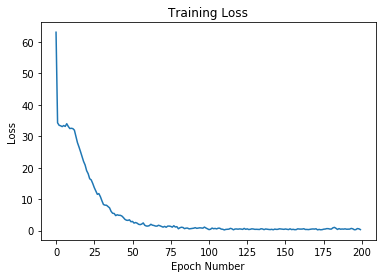

In [21]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

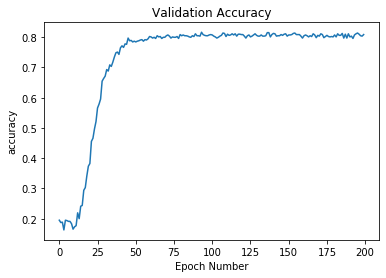

In [22]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")

In [51]:
x = torch.zeros(1,2,3,4)
print(x.view(1,2,12,1))

tensor([[[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]]]])
